# Home Photovoltaic System Simulation

Planning a PV system involves navigating many conflicting offers and technical options. 
This notebook analyzes my home and estimate the economic viability of different PV system offerings.

**To reproduce this for your home:**
1.  Get your electricity usage data (From your smart meter, home automation system, etc).
2.  Download TMY weather data for your location (PVGIS or DWD).
3.  Adjust the location and heat pump parameters in the notebook.
4.  Run the simulation to check your own scenarios.

## Input variables and data

In [1]:
import polars as pl
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy_financial as npf
import numpy as np
import seaborn.objects as so
from dataclasses import dataclass

%matplotlib inline
sns.set_style("darkgrid")
%load_ext jupyter_black

In [2]:
# # Heating parameters
# design_outdoor_temperature = (
#     -9.2
# )  # "Normaussentemperatur": Standardized/design outdoor temperature for heating calculations
# design_heating_load = (
#     8  # "Heizlast": Heating load at the design outdoor temperature in kW
# )
# heating_threshold = 15  # "Heizgrenze": Temperature above which heating is not needed
# hot_water_thermal_heating_demand_per_day_kwh = 12.0

# Data sources
reference_electricity_consumption_file = (
    "data/Stromverbrauch_data-03.12.2023,22-31-19.csv"
)
reference_weather_file = "data/produkt_klima_tag_19570701_20221231_02667_kb.txt"
real_heatpump_electricity_demand_file = "data/vitocal-electricity-demand.csv"
simulated_heatpump_electricity_demand_file = (
    "generated-data/simulated-heating-electricity.csv"
)
real_energy_flows_file = "data/energy-flows-2025-grafana.csv"
simulated_energy_flows_file = "generated-data/simulated-energy-flows.csv"

# # PV system orientations
# orientations = {
#     "southwest": dict(surface_tilt=44, surface_azimuth=210),
#     "facade": dict(surface_tilt=90, surface_azimuth=140),
# }
# kwp_facade = 1.74
# kwp_southwest = 14.875
# kwh_battery = 9.6 * 0.8

# Electricity prices
feed_in_price = 0.0811
electricity_price = 0.32

# Step 1: Electricity Demand

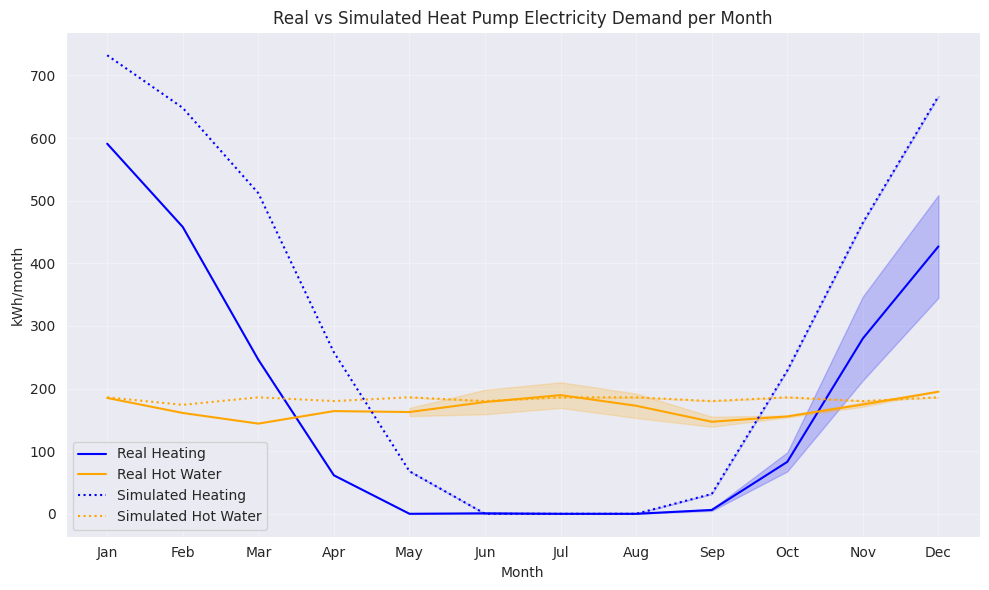


HEAT PUMP ELECTRICITY DEMAND - KEY PERFORMANCE INDICATORS


Metric,Real System,Simulated System
Annual Heating Electricity (kWh),"2,950.0","3,610.7"
Annual Hot Water Electricity (kWh),"3,404.0","2,196.0"
Annual Total Electricity (kWh),"6,351.7","5,806.7"
Heating Share (%),46.4,62.2
Hot Water Share (%),53.6,37.8
Difference vs Simulated (%),9.4,0.0


In [3]:
# Load real heat pump electricity demand data
heating_data = (
    pl.read_csv(real_heatpump_electricity_demand_file)
    .with_columns(
        pl.col("month").str.strptime(pl.Date, "%Y-%m").dt.month().alias("Month")
    )
    .select(["Month", "heating", "water", "total"])
    .rename(
        {
            "heating": "HeatingElectricity_kwh",
            "water": "HotWaterElectricity_kwh",
            "total": "TotalElectricity_kwh",
        }
    )
    .sort("Month")
)

# Load simulated heat pump electricity demand data
simulated_data = (
    pl.read_csv(simulated_heatpump_electricity_demand_file)
    .with_columns(pl.col("month").alias("Month"))  # month is already an integer (i8)
    .select(["Month", "heating", "water", "total"])
    .rename(
        {
            "heating": "SimulatedHeatingElectricity_kwh",
            "water": "SimulatedHotWaterElectricity_kwh",
            "total": "SimulatedTotalElectricity_kwh",
        }
    )
    .sort("Month")
)

# Combine real and simulated data for plotting
combined_data = heating_data.join(simulated_data, on="Month", how="left").select(
    [
        "Month",
        "HeatingElectricity_kwh",
        "HotWaterElectricity_kwh",
        "SimulatedHeatingElectricity_kwh",
        "SimulatedHotWaterElectricity_kwh",
    ]
)

# Plot real data as solid lines and simulated data as dotted lines
plt.figure(figsize=(10, 6))

# Real data (solid lines)
sns.lineplot(
    data=combined_data.to_pandas(),
    x="Month",
    y="HeatingElectricity_kwh",
    label="Real Heating",
    linestyle="-",
    color="blue",
)
sns.lineplot(
    data=combined_data.to_pandas(),
    x="Month",
    y="HotWaterElectricity_kwh",
    label="Real Hot Water",
    linestyle="-",
    color="orange",
)

# Simulated data (dotted lines)
sns.lineplot(
    data=combined_data.to_pandas(),
    x="Month",
    y="SimulatedHeatingElectricity_kwh",
    label="Simulated Heating",
    linestyle=":",
    color="blue",
)
sns.lineplot(
    data=combined_data.to_pandas(),
    x="Month",
    y="SimulatedHotWaterElectricity_kwh",
    label="Simulated Hot Water",
    linestyle=":",
    color="orange",
)

plt.title("Real vs Simulated Heat Pump Electricity Demand per Month")
plt.xlabel("Month")
plt.ylabel("kWh/month")
plt.xticks(range(1, 13))
plt.gca().set_xticklabels(
    ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate KPIs
real_heating_total = heating_data["HeatingElectricity_kwh"].sum()
real_water_total = heating_data["HotWaterElectricity_kwh"].sum()
real_total = heating_data["TotalElectricity_kwh"].sum()

simulated_heating_total = simulated_data["SimulatedHeatingElectricity_kwh"].sum()
simulated_water_total = simulated_data["SimulatedHotWaterElectricity_kwh"].sum()
simulated_total = simulated_data["SimulatedTotalElectricity_kwh"].sum()

# Create KPI summary table
kpi_summary = pd.DataFrame(
    {
        "Metric": [
            "Annual Heating Electricity (kWh)",
            "Annual Hot Water Electricity (kWh)",
            "Annual Total Electricity (kWh)",
            "Heating Share (%)",
            "Hot Water Share (%)",
            "Difference vs Simulated (%)",
        ],
        "Real System": [
            real_heating_total,
            real_water_total,
            real_total,
            (real_heating_total / real_total * 100),
            (real_water_total / real_total * 100),
            ((real_total - simulated_total) / simulated_total * 100),
        ],
        "Simulated System": [
            simulated_heating_total,
            simulated_water_total,
            simulated_total,
            (simulated_heating_total / simulated_total * 100),
            (simulated_water_total / simulated_total * 100),
            0,
        ],
    }
)

print("\n" + "=" * 80)
print("HEAT PUMP ELECTRICITY DEMAND - KEY PERFORMANCE INDICATORS")
print("=" * 80)

display(
    kpi_summary.style.format(
        {
            "Real System": "{:,.1f}",
            "Simulated System": "{:,.1f}",
        }
    ).hide(axis="index")
)

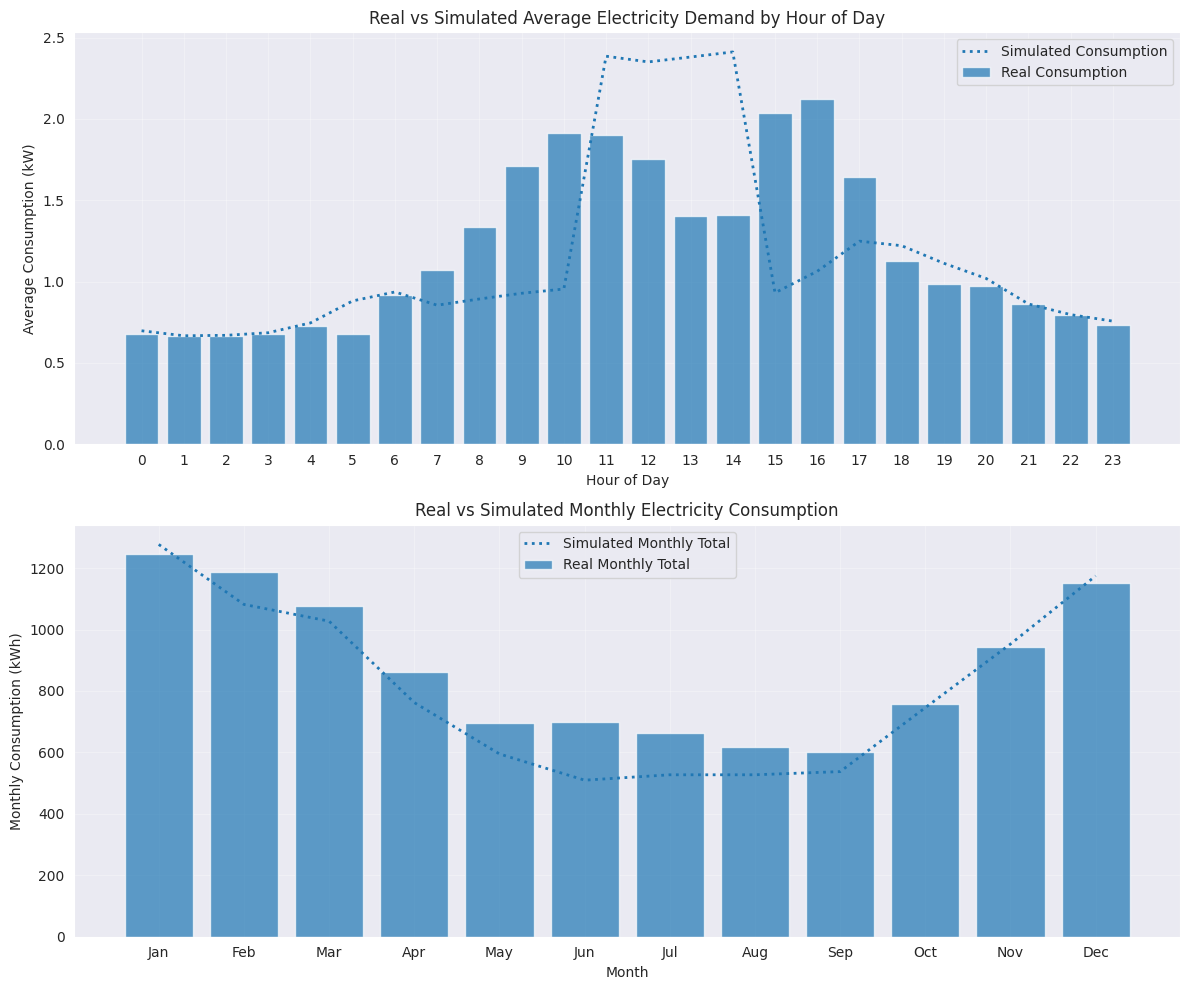

Metric,Value
Real Avg Daily,1.199
Simulated Avg Daily,1.144
Real Yearly Total,10500.557
Simulated Yearly Total,10019.582
Real Yearly (from Monthly),10500.557
Simulated Yearly (from Monthly),9717.622
Difference (%),4.580


In [4]:
# Load real energy flows data (Grafana export)
real_energy_flows = (
    pl.read_csv(
        real_energy_flows_file,
        null_values="undefined",  # Handle "undefined" values as null
        try_parse_dates=False,
    )
    .with_columns(
        [
            pl.col("Time").cast(pl.Int64).alias("timestamp_ms"),
            pl.col("Verbrauch").cast(pl.Float64).alias("RealConsumption"),
        ]
    )
    .with_columns(
        [pl.col("RealConsumption").fill_null(0.0)]  # Replace undefined/null with 0.0
    )
    .with_columns(pl.from_epoch("timestamp_ms", time_unit="ms").alias("DateTime"))
    .with_columns(
        [
            pl.col("DateTime").dt.hour().alias("Hour"),
            pl.col("DateTime").dt.month().alias("Month"),
        ]
    )
    .group_by("Hour")
    .agg([pl.col("RealConsumption").mean().alias("AvgRealConsumption")])
    .sort("Hour")
)

# Load real energy flows data for monthly analysis
real_monthly_flows = (
    pl.read_csv(
        real_energy_flows_file,
        null_values="undefined",  # Handle "undefined" values as null
        try_parse_dates=False,
    )
    .with_columns(
        [
            pl.col("Time").cast(pl.Int64).alias("timestamp_ms"),
            pl.col("Verbrauch").cast(pl.Float64).alias("RealConsumption"),
        ]
    )
    .with_columns(
        [pl.col("RealConsumption").fill_null(0.0)]  # Replace undefined/null with 0.0
    )
    .with_columns(pl.from_epoch("timestamp_ms", time_unit="ms").alias("DateTime"))
    .with_columns([pl.col("DateTime").dt.month().alias("Month")])
    .group_by("Month")
    .agg([pl.col("RealConsumption").sum().alias("MonthlyRealConsumption")])
    .sort("Month")
)

# Load simulated energy flows data
simulated_energy_flows = (
    pl.read_csv(simulated_energy_flows_file)
    .with_columns(
        [
            pl.col("TotalConsumption").cast(pl.Float64).alias("SimulatedConsumption"),
            pl.col("Hour").cast(pl.Int32),
        ]
    )
    .group_by("Hour")
    .agg([pl.col("SimulatedConsumption").mean().alias("AvgSimulatedConsumption")])
    .sort("Hour")
)

# Load simulated energy flows data for monthly analysis
simulated_monthly_flows = (
    pl.read_csv(simulated_energy_flows_file)
    .with_columns(
        [
            pl.col("TotalConsumption").cast(pl.Float64).alias("SimulatedConsumption"),
            pl.col("Month").cast(pl.Int32),
        ]
    )
    .group_by("Month")
    .agg([pl.col("SimulatedConsumption").sum().alias("MonthlySimulatedConsumption")])
    .sort("Month")
)

# Combine hourly datasets for comparison
combined_consumption = (
    real_energy_flows.join(simulated_energy_flows, on="Hour", how="full")
    .fill_null(strategy="forward")
    .fill_null(strategy="backward")
)

# Combine monthly datasets for comparison
combined_monthly = (
    real_monthly_flows.join(simulated_monthly_flows, on="Month", how="full")
    .fill_null(strategy="forward")
    .fill_null(strategy="backward")
)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot 1: Hourly comparison
bars1 = ax1.bar(
    combined_consumption["Hour"],
    combined_consumption["AvgRealConsumption"],
    label="Real Consumption",
    alpha=0.7,
)
ax1.plot(
    combined_consumption["Hour"],
    combined_consumption["AvgSimulatedConsumption"],
    label="Simulated Consumption",
    linestyle=":",
    linewidth=2,
)

ax1.set_title("Real vs Simulated Average Electricity Demand by Hour of Day")
ax1.set_xlabel("Hour of Day")
ax1.set_ylabel("Average Consumption (kW)")
ax1.set_xticks(range(0, 24))
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: Monthly comparison
bars2 = ax2.bar(
    combined_monthly["Month"],
    combined_monthly["MonthlyRealConsumption"],
    label="Real Monthly Total",
    alpha=0.7,
)
ax2.plot(
    combined_monthly["Month"],
    combined_monthly["MonthlySimulatedConsumption"],
    label="Simulated Monthly Total",
    linestyle=":",
    linewidth=2,
)

ax2.set_title("Real vs Simulated Monthly Electricity Consumption")
ax2.set_xlabel("Month")
ax2.set_ylabel("Monthly Consumption (kWh)")
ax2.set_xticks(range(1, 13))
ax2.set_xticklabels(
    ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
)
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

# Calculate yearly totals (24 hours * 365 days)
real_yearly_total = combined_consumption["AvgRealConsumption"].sum() * 365
simulated_yearly_total = combined_consumption["AvgSimulatedConsumption"].sum() * 365

# Also calculate from monthly data for verification
real_yearly_from_monthly = combined_monthly["MonthlyRealConsumption"].sum()
simulated_yearly_from_monthly = combined_monthly["MonthlySimulatedConsumption"].sum()

# Display summary statistics
summary_stats = pd.DataFrame(
    {
        "Metric": [
            "Real Avg Daily",
            "Simulated Avg Daily",
            "Real Yearly Total",
            "Simulated Yearly Total",
            "Real Yearly (from Monthly)",
            "Simulated Yearly (from Monthly)",
            "Difference (%)",
        ],
        "Value": [
            combined_consumption["AvgRealConsumption"].mean(),
            combined_consumption["AvgSimulatedConsumption"].mean(),
            real_yearly_total,
            simulated_yearly_total,
            real_yearly_from_monthly,
            simulated_yearly_from_monthly,
            (
                (
                    combined_consumption["AvgRealConsumption"].mean()
                    - combined_consumption["AvgSimulatedConsumption"].mean()
                )
                / combined_consumption["AvgRealConsumption"].mean()
                * 100
            ),
        ],
    }
)

display(summary_stats.style.format({"Value": "{:.3f}"}).hide(axis="index"))

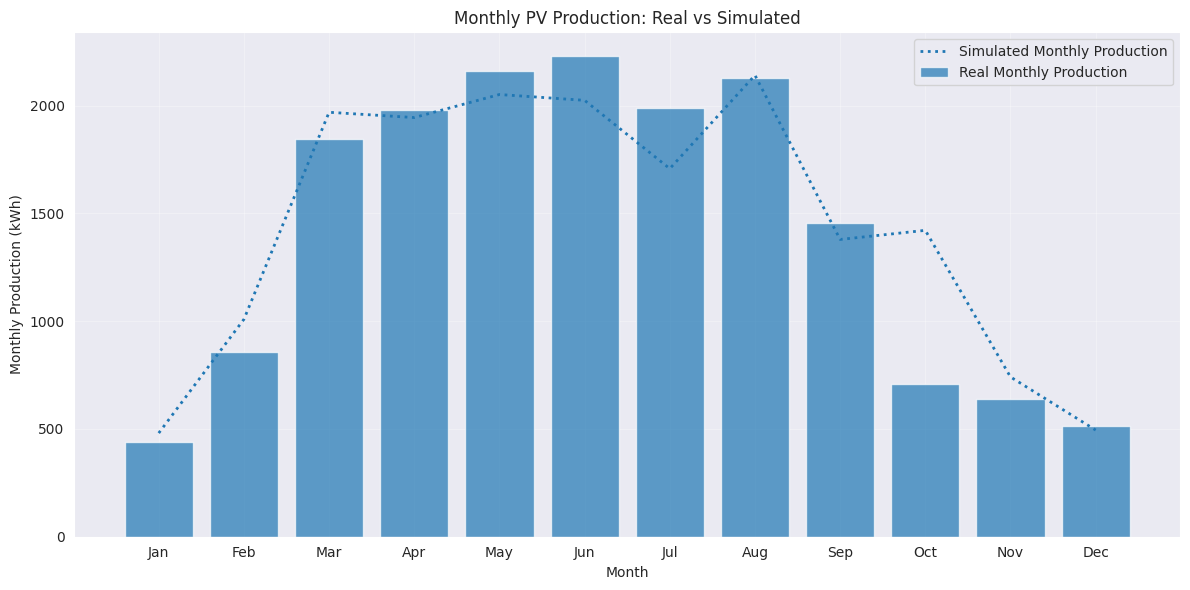

Metric,Value
Real Yearly Total,16941.0
Simulated Yearly Total,17362.5
Difference (%),2.5


Real yearly production: 16941.0 kWh
Simulated yearly production: 17362.5 kWh


In [5]:
# Load real PV production data from energy flows
real_pv_data = (
    pl.read_csv(
        real_energy_flows_file,
        null_values="undefined",
        try_parse_dates=False,
    )
    .with_columns(
        [
            pl.col("Time").cast(pl.Int64).alias("timestamp_ms"),
            pl.col("DachPV").cast(pl.Float64).fill_null(0.0).alias("RoofPV"),
            pl.col("Fassaden-PV").cast(pl.Float64).fill_null(0.0).alias("FacadePV"),
        ]
    )
    .with_columns(pl.from_epoch("timestamp_ms", time_unit="ms").alias("DateTime"))
    .with_columns(
        [
            pl.col("DateTime").dt.month().alias("Month"),
            (pl.col("RoofPV") + pl.col("FacadePV")).alias("TotalPV"),
        ]
    )
    .group_by("Month")
    .agg([pl.col("TotalPV").sum().alias("TotalPV_monthly")])
    .sort("Month")
)

# Load simulated PV production data
simulated_pv_data = (
    pl.read_csv(simulated_energy_flows_file)
    .with_columns(
        [
            pl.col("Production").cast(pl.Float64).alias("TotalPV"),
            pl.col("Month").cast(pl.Int32),
        ]
    )
    .group_by("Month")
    .agg([pl.col("TotalPV").sum().alias("TotalPV_monthly")])
    .sort("Month")
)

# Combine real and simulated data for comparison
combined_pv = (
    real_pv_data.join(simulated_pv_data, on="Month", how="full")
    .fill_null(strategy="forward")
    .fill_null(strategy="backward")
)

# Create bar chart with real values and dotted line for simulation
plt.figure(figsize=(12, 6))

# Bar chart for real values
bars = plt.bar(
    combined_pv["Month"],
    combined_pv["TotalPV_monthly"],
    label="Real Monthly Production",
    alpha=0.7,
)

# Dotted line for simulated values
plt.plot(
    combined_pv["Month"],
    combined_pv["TotalPV_monthly_right"],
    label="Simulated Monthly Production",
    linestyle=":",
    linewidth=2,
)

plt.title("Monthly PV Production: Real vs Simulated")
plt.xlabel("Month")
plt.ylabel("Monthly Production (kWh)")
plt.xticks(range(1, 13))
plt.gca().set_xticklabels(
    ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Display summary statistics
pv_summary = pd.DataFrame(
    {
        "Metric": ["Real Yearly Total", "Simulated Yearly Total", "Difference (%)"],
        "Value": [
            real_pv_data["TotalPV_monthly"].sum(),
            simulated_pv_data["TotalPV_monthly"].sum(),
            (
                (
                    simulated_pv_data["TotalPV_monthly"].sum()
                    - real_pv_data["TotalPV_monthly"].sum()
                )
                / real_pv_data["TotalPV_monthly"].sum()
                * 100
            ),
        ],
    }
)

display(pv_summary.style.format({"Value": "{:.1f}"}).hide(axis="index"))

print(f"Real yearly production: {real_pv_data['TotalPV_monthly'].sum():.1f} kWh")
print(
    f"Simulated yearly production: {simulated_pv_data['TotalPV_monthly'].sum():.1f} kWh"
)

# Step 3: Matching Demand and Production

Here we match the simulated production against our demand. We calculate self-consumption (min(demand, production)) and grid usage to understand the system's efficiency.

## Example simulation

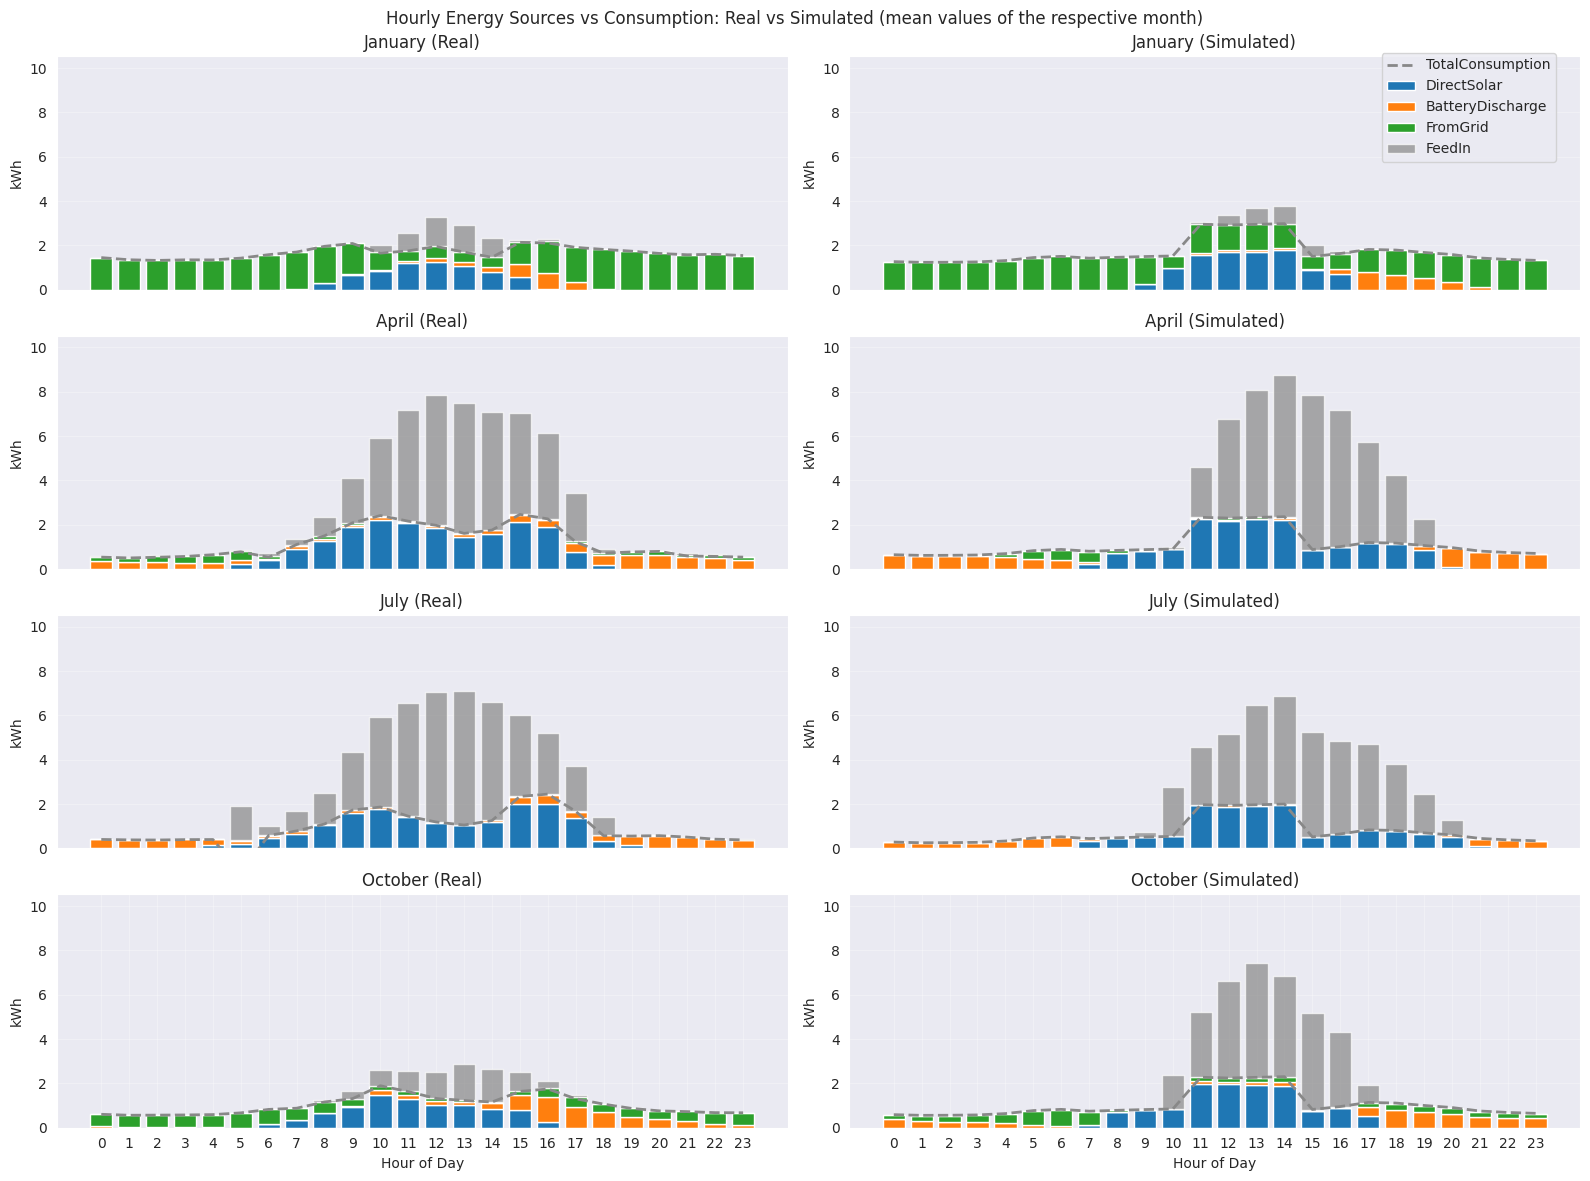

In [6]:
months = [1, 4, 7, 10]
month_name = {"1": "January", "4": "April", "7": "July", "10": "October"}

# Common columns for both datasets
common_columns = [
    pl.col("TotalConsumption").cast(pl.Float64),
    pl.col("Month").cast(pl.Int32),
    pl.col("Hour").cast(pl.Int32),
]


# Helper function to load and process energy data
def load_energy_data(file_path, is_real_data=False):
    df = pl.read_csv(file_path, null_values="undefined", try_parse_dates=False)

    if is_real_data:
        df = (
            df.with_columns(
                [
                    pl.col("Time").cast(pl.Int64).alias("timestamp_ms"),
                    pl.col("DachPV").cast(pl.Float64).fill_null(0.0).alias("RoofPV"),
                    pl.col("Fassaden-PV")
                    .cast(pl.Float64)
                    .fill_null(0.0)
                    .alias("FacadePV"),
                    pl.col("Batterie-Entladung")
                    .cast(pl.Float64)
                    .fill_null(0.0)
                    .alias("BatteryDischarge"),
                    pl.col("Batterie-Ladung")
                    .cast(pl.Float64)
                    .fill_null(0.0)
                    .alias("BatteryCharge"),
                    pl.col("Netzbezug")
                    .cast(pl.Float64)
                    .fill_null(0.0)
                    .alias("FromGrid"),
                    pl.col("Einspeisung")
                    .cast(pl.Float64)
                    .fill_null(0.0)
                    .alias("FeedIn"),
                    pl.col("Verbrauch")
                    .cast(pl.Float64)
                    .fill_null(0.0)
                    .alias("TotalConsumption"),
                ]
            )
            .with_columns(
                pl.from_epoch("timestamp_ms", time_unit="ms").alias("DateTime")
            )
            .with_columns(
                [
                    pl.col("DateTime").dt.hour().alias("Hour"),
                    pl.col("DateTime").dt.month().alias("Month"),
                    (pl.col("RoofPV") + pl.col("FacadePV")).alias(
                        "TotalSolarProduction"
                    ),
                ]
            )
        )
    else:
        df = df.with_columns(
            [
                pl.col("Production").cast(pl.Float64).alias("TotalSolarProduction"),
                pl.col("TotalConsumption").cast(pl.Float64),
                pl.col("FromGrid").cast(pl.Float64),
                pl.col("FeedIn").cast(pl.Float64),
                pl.col("ChargingPower").cast(pl.Float64),
                pl.col("Month").cast(pl.Int32),
                pl.col("Hour").cast(pl.Int32),
            ]
        ).with_columns(
            [
                (-pl.col("ChargingPower").clip(upper_bound=0)).alias(
                    "BatteryDischarge"
                ),
                (pl.col("ChargingPower").clip(lower_bound=0)).alias("BatteryCharge"),
            ]
        )

    # Common processing for both datasets
    return (
        df.with_columns(
            [
                (
                    pl.col("TotalConsumption")
                    - pl.col("BatteryDischarge")
                    - pl.col("FromGrid")
                )
                .clip(lower_bound=0, upper_bound=pl.col("TotalSolarProduction"))
                .alias("DirectSolar")
            ]
        )
        .filter(pl.col("Month").is_in(months))
        .group_by([pl.col("Month"), pl.col("Hour")])
        .agg(
            [
                pl.col("TotalConsumption").mean(),
                pl.col("TotalSolarProduction").mean(),
                pl.col("BatteryCharge").mean(),
                pl.col("BatteryDischarge").mean(),
                pl.col("FromGrid").mean(),
                pl.col("FeedIn").mean(),
                pl.col("DirectSolar").mean(),
            ]
        )
        .sort(["Month", "Hour"])
        .with_columns(pl.col("Month").cast(pl.Utf8).replace(month_name))
        .with_columns(pl.col("FeedIn").abs())
    )


# Load both datasets
real_hourly_data = load_energy_data(real_energy_flows_file, is_real_data=True)
simulated_hourly = load_energy_data(simulated_energy_flows_file, is_real_data=False)

# Calculate global y-axis limits
ordered_months = [month_name[str(m)] for m in months]
all_values = []
for month_name_str in ordered_months:
    for df in [real_hourly_data, simulated_hourly]:
        month_data = df.filter(pl.col("Month") == month_name_str).to_pandas()
        all_values.extend(
            (month_data["TotalConsumption"] + month_data["FeedIn"]).values
        )

global_max = max(all_values) * 1.2

# Energy flows and colors
consumption_flows = ["DirectSolar", "BatteryDischarge", "FromGrid"]
colors = sns.color_palette()
source_colors = {source: colors[i] for i, source in enumerate(consumption_flows)}
source_colors["FeedIn"] = "#888888"

# Create figure with 8 subplots (4 months × 2 datasets)
fig, axes = plt.subplots(4, 2, figsize=(16, 12))
fig.suptitle(
    "Hourly Energy Sources vs Consumption: Real vs Simulated "
    "(mean values of the respective month)"
)

for i, month_name_str in enumerate(ordered_months):
    for col, (df, title_suffix) in enumerate(
        [(real_hourly_data, "Real"), (simulated_hourly, "Simulated")]
    ):
        month_data = df.filter(pl.col("Month") == month_name_str).to_pandas()

        # Stack consumption sources
        bottom = np.zeros(len(month_data))
        for source in consumption_flows:
            axes[i, col].bar(
                month_data["Hour"],
                month_data[source],
                bottom=bottom,
                label=source if i == 0 and col == 0 else None,
                color=source_colors[source],
            )
            bottom += month_data[source].values

        # Add FeedIn on top
        axes[i, col].bar(
            month_data["Hour"],
            month_data["FeedIn"],
            bottom=bottom,
            label="FeedIn" if i == 0 and col == 0 else None,
            color=source_colors["FeedIn"],
            alpha=0.7,
        )

        # Plot total consumption line
        axes[i, col].plot(
            month_data["Hour"],
            month_data["TotalConsumption"],
            color="#888",
            linewidth=2,
            linestyle="--",
            label="TotalConsumption" if i == 0 and col == 0 else None,
        )

        axes[i, col].set_title(f"{month_name_str} ({title_suffix})")
        axes[i, col].set_ylabel("kWh")
        axes[i, col].set_ylim(0, global_max)
        axes[i, col].grid(True, alpha=0.3)

        # Set x-axis labels for bottom row only
        if i == 3:
            axes[i, col].set_xlabel("Hour of Day")
            axes[i, col].set_xticks(range(0, 24))
        else:
            axes[i, col].set_xticks([])

fig.legend(loc="upper right", bbox_to_anchor=(0.98, 0.95))
plt.tight_layout()
plt.show()

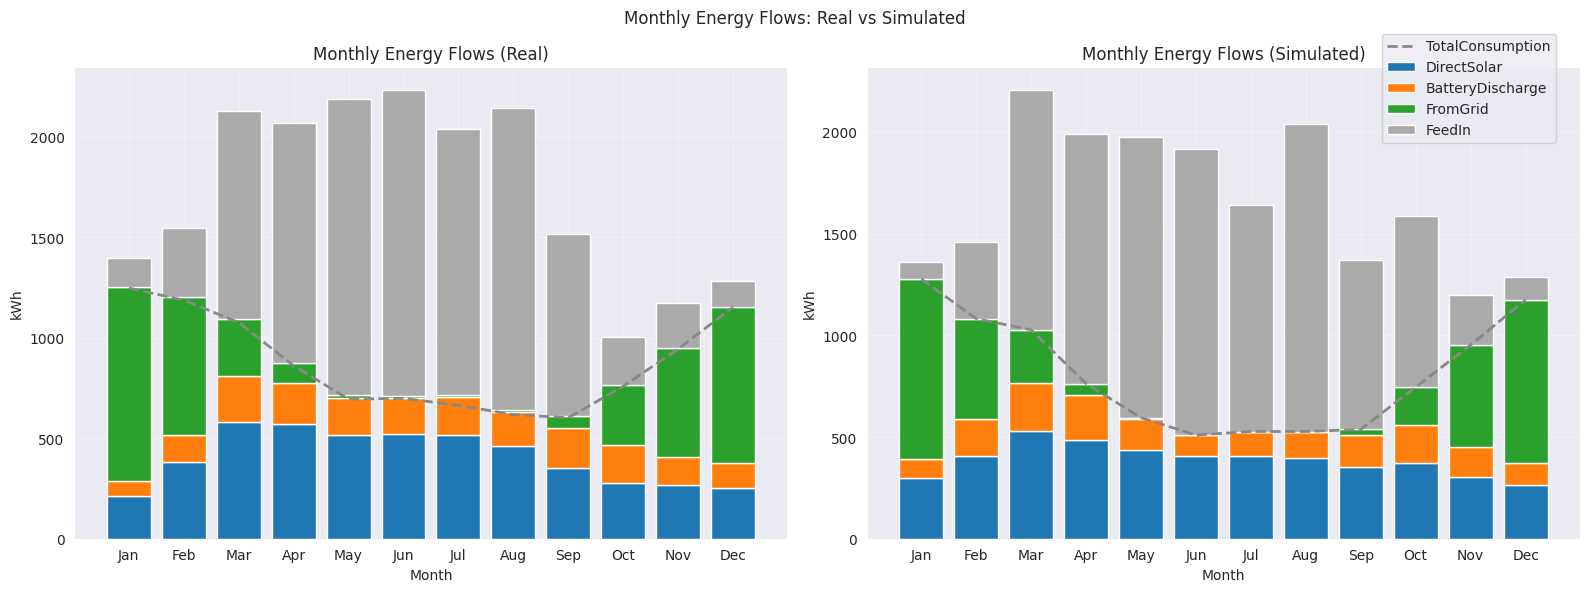

In [7]:
# Monthly totals: Energy flows - Real vs Simulated


# Helper function to aggregate monthly energy flows
def load_monthly_energy_data(file_path, is_real_data=False):
    df = pl.read_csv(file_path, null_values="undefined", try_parse_dates=False)

    if is_real_data:
        df = (
            df.with_columns(
                [
                    pl.col("Time").cast(pl.Int64).alias("timestamp_ms"),
                    pl.col("DachPV").cast(pl.Float64).fill_null(0.0).alias("RoofPV"),
                    pl.col("Fassaden-PV")
                    .cast(pl.Float64)
                    .fill_null(0.0)
                    .alias("FacadePV"),
                    pl.col("Batterie-Entladung")
                    .cast(pl.Float64)
                    .fill_null(0.0)
                    .alias("BatteryDischarge"),
                    pl.col("Batterie-Ladung")
                    .cast(pl.Float64)
                    .fill_null(0.0)
                    .alias("BatteryCharge"),
                    pl.col("Netzbezug")
                    .cast(pl.Float64)
                    .fill_null(0.0)
                    .alias("FromGrid"),
                    pl.col("Einspeisung")
                    .cast(pl.Float64)
                    .fill_null(0.0)
                    .alias("FeedIn"),
                    pl.col("Verbrauch")
                    .cast(pl.Float64)
                    .fill_null(0.0)
                    .alias("TotalConsumption"),
                ]
            )
            .with_columns(
                pl.from_epoch("timestamp_ms", time_unit="ms").alias("DateTime")
            )
            .with_columns(
                [
                    pl.col("DateTime").dt.month().alias("Month"),
                    (pl.col("RoofPV") + pl.col("FacadePV")).alias(
                        "TotalSolarProduction"
                    ),
                ]
            )
        )
    else:
        df = df.with_columns(
            [
                pl.col("Production").cast(pl.Float64).alias("TotalSolarProduction"),
                pl.col("TotalConsumption").cast(pl.Float64),
                pl.col("FromGrid").cast(pl.Float64),
                pl.col("FeedIn").cast(pl.Float64),
                pl.col("ChargingPower").cast(pl.Float64),
                pl.col("Month").cast(pl.Int32),
            ]
        ).with_columns(
            [
                (-pl.col("ChargingPower").clip(upper_bound=0)).alias(
                    "BatteryDischarge"
                ),
                (pl.col("ChargingPower").clip(lower_bound=0)).alias("BatteryCharge"),
            ]
        )

    # Calculate DirectSolar and aggregate by month
    return (
        df.with_columns(
            [
                (
                    pl.col("TotalConsumption")
                    - pl.col("BatteryDischarge")
                    - pl.col("FromGrid")
                )
                .clip(lower_bound=0, upper_bound=pl.col("TotalSolarProduction"))
                .alias("DirectSolar")
            ]
        )
        .group_by("Month")
        .agg(
            [
                pl.col("TotalConsumption").sum(),
                pl.col("DirectSolar").sum(),
                pl.col("BatteryDischarge").sum(),
                pl.col("FromGrid").sum(),
                pl.col("FeedIn").sum().abs(),
            ]
        )
        .sort("Month")
    )


# Load monthly data for both real and simulated
real_monthly = load_monthly_energy_data(real_energy_flows_file, is_real_data=True)
simulated_monthly = load_monthly_energy_data(
    simulated_energy_flows_file, is_real_data=False
)

# Energy flows and colors
flows = ["DirectSolar", "BatteryDischarge", "FromGrid", "FeedIn"]
colors = sns.color_palette()
source_colors = {source: colors[i] for i, source in enumerate(flows)}
source_colors["FeedIn"] = "#AAA"

# Create figure with 2 subplots (Real and Simulated)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("Monthly Energy Flows: Real vs Simulated")

for ax, (df, title_suffix) in zip(
    [ax1, ax2], [(real_monthly, "Real"), (simulated_monthly, "Simulated")]
):
    monthly_pd = df.to_pandas()

    # Stacked bars for energy flows
    bottom = np.zeros(len(monthly_pd))
    for source in flows:
        ax.bar(
            monthly_pd["Month"],
            monthly_pd[source],
            bottom=bottom,
            label=source if ax == ax1 else None,
            color=source_colors[source],
        )
        bottom += monthly_pd[source].values

    # Line for total consumption
    ax.plot(
        monthly_pd["Month"],
        monthly_pd["TotalConsumption"],
        color="#888",
        linewidth=2,
        linestyle="--",
        label="TotalConsumption" if ax == ax1 else None,
    )

    ax.set_title(f"Monthly Energy Flows ({title_suffix})")
    ax.set_xlabel("Month")
    ax.set_ylabel("kWh")
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(
        [
            "Jan",
            "Feb",
            "Mar",
            "Apr",
            "May",
            "Jun",
            "Jul",
            "Aug",
            "Sep",
            "Oct",
            "Nov",
            "Dec",
        ]
    )
    ax.grid(True, alpha=0.3)

# Single legend for the whole figure
fig.legend(loc="upper right", bbox_to_anchor=(0.98, 0.95))
plt.tight_layout()
plt.show()

# Step 4: Investment calculation

We translate the energy flows into Euros using investment costs, electricity prices, and feed-in tariffs. We calculate the Net Present Value (NPV) to assess profitability.

ECONOMIC COMPARISON: PV System vs No PV System


Scenario,Total Consumption (kWh),Grid Purchase (kWh),Feed-in (kWh),Grid Cost (€),Feed-in Revenue (€),Net Annual Cost (€),Annual Savings vs No PV (€)
Real PV System,"10,501","3,747","10,043","1,198.96",814.47,384.49,"2,975.69"
Simulated PV System,"9,718","3,219","10,313","1,029.93",836.37,193.56,"3,166.62"
No PV (Baseline),"10,501","10,501",0,"3,360.18",0.00,"3,360.18",0.00



KEY METRICS

Real System:
  Self-sufficiency rate: 64.3%
  Annual savings: €2,975.69
  Cost reduction: 88.6%

Simulated System:
  Self-sufficiency rate: 66.9%
  Annual savings: €3,166.62
  Cost reduction: 94.2%


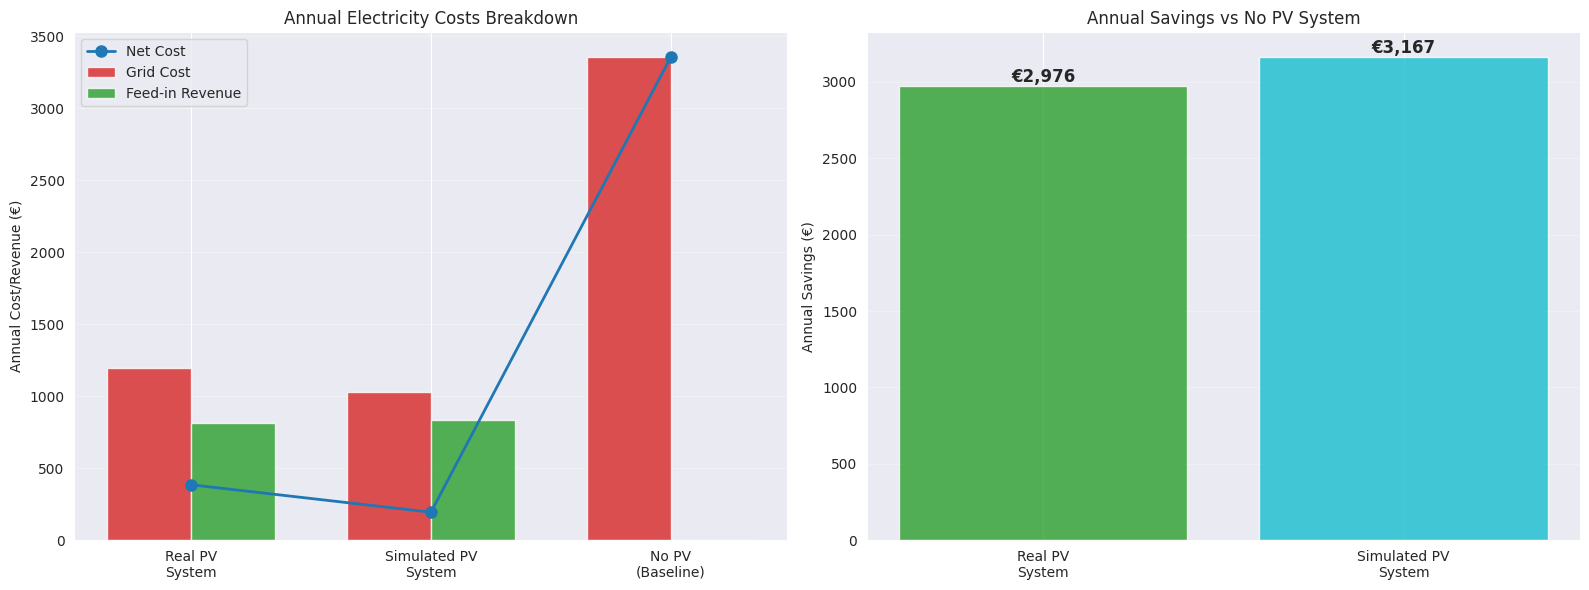

In [8]:
# Economic Analysis: Cost Comparison

# Calculate yearly totals for real and simulated systems
real_yearly_totals = real_monthly.select(
    [
        pl.col("TotalConsumption").sum().alias("TotalConsumption"),
        pl.col("FromGrid").sum().alias("FromGrid"),
        pl.col("FeedIn").sum().alias("FeedIn"),
        pl.col("DirectSolar").sum().alias("DirectSolar"),
        pl.col("BatteryDischarge").sum().alias("BatteryDischarge"),
    ]
)

simulated_yearly_totals = simulated_monthly.select(
    [
        pl.col("TotalConsumption").sum().alias("TotalConsumption"),
        pl.col("FromGrid").sum().alias("FromGrid"),
        pl.col("FeedIn").sum().alias("FeedIn"),
        pl.col("DirectSolar").sum().alias("DirectSolar"),
        pl.col("BatteryDischarge").sum().alias("BatteryDischarge"),
    ]
)

# Extract values
real_consumption = real_yearly_totals["TotalConsumption"][0]
real_from_grid = real_yearly_totals["FromGrid"][0]
real_feed_in = real_yearly_totals["FeedIn"][0]

simulated_consumption = simulated_yearly_totals["TotalConsumption"][0]
simulated_from_grid = simulated_yearly_totals["FromGrid"][0]
simulated_feed_in = simulated_yearly_totals["FeedIn"][0]

# Calculate costs and earnings for each scenario
# Scenario 1: Real PV System
real_grid_cost = real_from_grid * electricity_price
real_feed_in_revenue = real_feed_in * feed_in_price
real_net_cost = real_grid_cost - real_feed_in_revenue

# Scenario 2: Simulated PV System
simulated_grid_cost = simulated_from_grid * electricity_price
simulated_feed_in_revenue = simulated_feed_in * feed_in_price
simulated_net_cost = simulated_grid_cost - simulated_feed_in_revenue

# Scenario 3: No PV System (Baseline) - buy all electricity from grid (using real consumption)
baseline_cost = real_consumption * electricity_price

# Calculate savings compared to baseline
real_savings = baseline_cost - real_net_cost
simulated_savings = baseline_cost - simulated_net_cost

# Create comparison dataframe
comparison_df = pd.DataFrame(
    {
        "Scenario": [
            "Real PV System",
            "Simulated PV System",
            "No PV (Baseline)",
        ],
        "Total Consumption (kWh)": [
            real_consumption,
            simulated_consumption,
            real_consumption,
        ],
        "Grid Purchase (kWh)": [
            real_from_grid,
            simulated_from_grid,
            real_consumption,
        ],
        "Feed-in (kWh)": [
            real_feed_in,
            simulated_feed_in,
            0,
        ],
        "Grid Cost (€)": [
            real_grid_cost,
            simulated_grid_cost,
            baseline_cost,
        ],
        "Feed-in Revenue (€)": [
            real_feed_in_revenue,
            simulated_feed_in_revenue,
            0,
        ],
        "Net Annual Cost (€)": [
            real_net_cost,
            simulated_net_cost,
            baseline_cost,
        ],
        "Annual Savings vs No PV (€)": [
            real_savings,
            simulated_savings,
            0,
        ],
    }
)

# Display the comparison table
print("=" * 80)
print("ECONOMIC COMPARISON: PV System vs No PV System")
print("=" * 80)
display(
    comparison_df.style.format(
        {
            "Total Consumption (kWh)": "{:,.0f}",
            "Grid Purchase (kWh)": "{:,.0f}",
            "Feed-in (kWh)": "{:,.0f}",
            "Grid Cost (€)": "{:,.2f}",
            "Feed-in Revenue (€)": "{:,.2f}",
            "Net Annual Cost (€)": "{:,.2f}",
            "Annual Savings vs No PV (€)": "{:,.2f}",
        }
    ).hide(axis="index")
)

# Calculate self-sufficiency rates
real_self_sufficiency = (1 - real_from_grid / real_consumption) * 100
simulated_self_sufficiency = (1 - simulated_from_grid / simulated_consumption) * 100

print("\n" + "=" * 80)
print("KEY METRICS")
print("=" * 80)
print(f"\nReal System:")
print(f"  Self-sufficiency rate: {real_self_sufficiency:.1f}%")
print(f"  Annual savings: €{real_savings:,.2f}")
print(f"  Cost reduction: {(real_savings / baseline_cost * 100):.1f}%")

print(f"\nSimulated System:")
print(f"  Self-sufficiency rate: {simulated_self_sufficiency:.1f}%")
print(f"  Annual savings: €{simulated_savings:,.2f}")
print(f"  Cost reduction: {(simulated_savings / baseline_cost * 100):.1f}%")

# Visualization: Cost comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Annual costs breakdown
scenarios = ["Real PV\nSystem", "Simulated PV\nSystem", "No PV\n(Baseline)"]
grid_costs = [real_grid_cost, simulated_grid_cost, baseline_cost]
feed_in_revenues = [real_feed_in_revenue, simulated_feed_in_revenue, 0]
net_costs = [real_net_cost, simulated_net_cost, baseline_cost]

x = np.arange(len(scenarios))
width = 0.35

bars1 = ax1.bar(
    x - width / 2, grid_costs, width, label="Grid Cost", color="#d62728", alpha=0.8
)
bars2 = ax1.bar(
    x + width / 2,
    feed_in_revenues,
    width,
    label="Feed-in Revenue",
    color="#2ca02c",
    alpha=0.8,
)

# Add net cost line
ax1.plot(
    x,
    net_costs,
    color="#1f77b4",
    marker="o",
    linewidth=2,
    markersize=8,
    label="Net Cost",
)

ax1.set_ylabel("Annual Cost/Revenue (€)")
ax1.set_title("Annual Electricity Costs Breakdown")
ax1.set_xticks(x)
ax1.set_xticklabels(scenarios)
ax1.legend()
ax1.grid(True, alpha=0.3, axis="y")

# Plot 2: Savings comparison
savings_data = [real_savings, simulated_savings]
savings_labels = ["Real PV\nSystem", "Simulated PV\nSystem"]
colors_savings = ["#2ca02c", "#17becf"]

bars = ax2.bar(savings_labels, savings_data, color=colors_savings, alpha=0.8)
ax2.set_ylabel("Annual Savings (€)")
ax2.set_title("Annual Savings vs No PV System")
ax2.grid(True, alpha=0.3, axis="y")

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax2.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"€{height:,.0f}",
        ha="center",
        va="bottom",
        fontsize=12,
        fontweight="bold",
    )

plt.tight_layout()
plt.show()

INVESTMENT ANALYSIS
Investment Cost: €25,500
Discount Rate: 3.0%
System Lifetime: 25 years


Metric,Real System,Simulated System
Initial Investment (€),"25,500.00","25,500.00"
Annual Savings (€),"2,975.69","3,166.62"
Payback Period (years),8.57,8.05
NPV @ 3% over 25 years (€),"26,316.09","29,640.85"
Total Savings over 25 years (€),"74,392.20","79,165.55"
ROI over 25 years (%),191.73,210.45


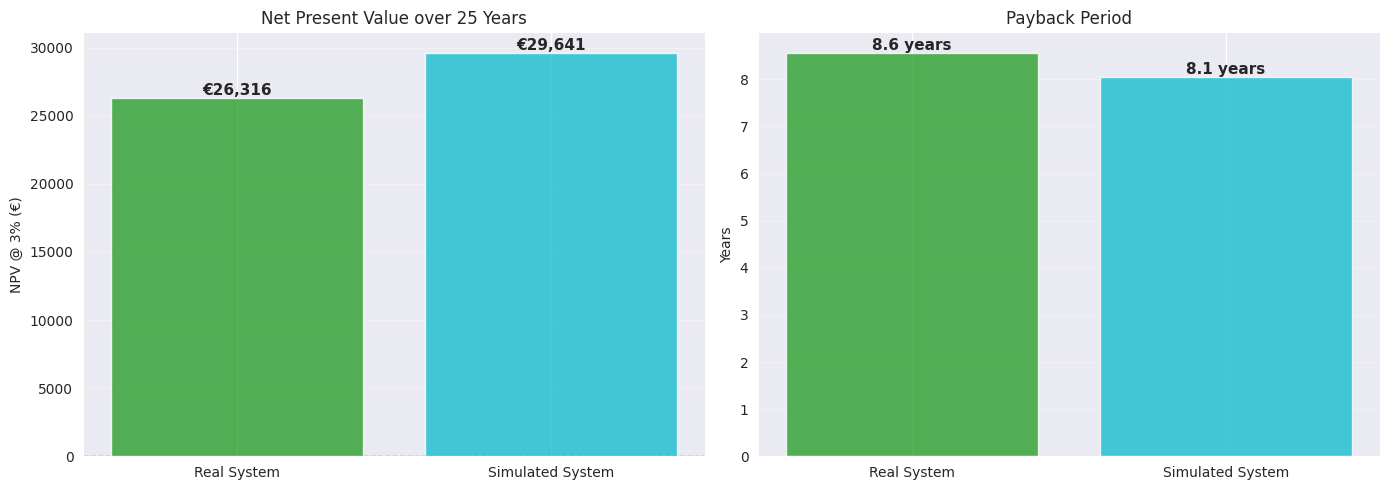


SUMMARY

Real System:
  • Payback period: 8.6 years
  • NPV: €26,316.09
  • ROI: 191.7%
  • Status: ✓ PROFITABLE

Simulated System:
  • Payback period: 8.1 years
  • NPV: €29,640.85
  • ROI: 210.5%
  • Status: ✓ PROFITABLE


In [9]:
# Investment Analysis: NPV and Amortization Period

# Investment parameters
investment_cost = 25500  # €
discount_rate = 0.03  # 3% discount rate
system_lifetime = 25  # years

# Calculate NPV for both scenarios
real_npv = npf.npv(discount_rate, [-investment_cost] + [real_savings] * system_lifetime)
simulated_npv = npf.npv(
    discount_rate, [-investment_cost] + [simulated_savings] * system_lifetime
)

# Calculate payback periods
real_payback_period = investment_cost / real_savings
simulated_payback_period = investment_cost / simulated_savings

# Calculate total savings and ROI
real_total_savings = real_savings * system_lifetime
simulated_total_savings = simulated_savings * system_lifetime
real_roi = ((real_total_savings - investment_cost) / investment_cost) * 100
simulated_roi = ((simulated_total_savings - investment_cost) / investment_cost) * 100

# Create summary dataframe
investment_summary = pd.DataFrame(
    {
        "Metric": [
            "Initial Investment (€)",
            "Annual Savings (€)",
            "Payback Period (years)",
            f"NPV @ {discount_rate*100:.0f}% over {system_lifetime} years (€)",
            f"Total Savings over {system_lifetime} years (€)",
            f"ROI over {system_lifetime} years (%)",
        ],
        "Real System": [
            investment_cost,
            real_savings,
            real_payback_period,
            real_npv,
            real_total_savings,
            real_roi,
        ],
        "Simulated System": [
            investment_cost,
            simulated_savings,
            simulated_payback_period,
            simulated_npv,
            simulated_total_savings,
            simulated_roi,
        ],
    }
)

print("=" * 80)
print("INVESTMENT ANALYSIS")
print("=" * 80)
print(f"Investment Cost: €{investment_cost:,.0f}")
print(f"Discount Rate: {discount_rate*100:.1f}%")
print(f"System Lifetime: {system_lifetime} years")
print("=" * 80)

display(
    investment_summary.style.format(
        {
            "Real System": "{:,.2f}",
            "Simulated System": "{:,.2f}",
        }
    ).hide(axis="index")
)

# Visualization: NPV and Payback comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: NPV comparison
npv_data = [real_npv, simulated_npv]
npv_labels = ["Real System", "Simulated System"]
colors = ["#2ca02c", "#17becf"]

bars1 = ax1.bar(npv_labels, npv_data, color=colors, alpha=0.8)
ax1.axhline(y=0, color="red", linestyle="--", linewidth=1, alpha=0.7)
ax1.set_ylabel(f"NPV @ {discount_rate*100:.0f}% (€)")
ax1.set_title(f"Net Present Value over {system_lifetime} Years")
ax1.grid(True, alpha=0.3, axis="y")

for bar in bars1:
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"€{height:,.0f}",
        ha="center",
        va="bottom" if height > 0 else "top",
        fontsize=11,
        fontweight="bold",
    )

# Plot 2: Payback period comparison
payback_data = [real_payback_period, simulated_payback_period]
bars2 = ax2.bar(npv_labels, payback_data, color=colors, alpha=0.8)
ax2.set_ylabel("Years")
ax2.set_title("Payback Period")
ax2.grid(True, alpha=0.3, axis="y")

for bar in bars2:
    height = bar.get_height()
    ax2.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{height:.1f} years",
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold",
    )

plt.tight_layout()
plt.show()

# Summary
print("\n" + "=" * 80)
print("SUMMARY")
print("=" * 80)
print(f"\nReal System:")
print(f"  • Payback period: {real_payback_period:.1f} years")
print(f"  • NPV: €{real_npv:,.2f}")
print(f"  • ROI: {real_roi:.1f}%")
print(f"  • Status: {'✓ PROFITABLE' if real_npv > 0 else '✗ NOT PROFITABLE'}")

print(f"\nSimulated System:")
print(f"  • Payback period: {simulated_payback_period:.1f} years")
print(f"  • NPV: €{simulated_npv:,.2f}")
print(f"  • ROI: {simulated_roi:.1f}%")
print(f"  • Status: {'✓ PROFITABLE' if simulated_npv > 0 else '✗ NOT PROFITABLE'}")

HEAT PUMP VS GAS BOILER COMPARISON
Electricity Price: €0.32/kWh
Gas Price: €0.11/kWh
System Lifetime: 20 years


Metric,Heat Pump,Gas Boiler
Initial Investment (€),"22,000.00","12,000.00"
Annual Thermal Energy Delivered (kWh),"24,811.70","24,811.70"
Annual Energy Consumption (kWh),"6,351.70","26,117.58"
System Efficiency (COP / η),3.91,0.95
Annual Operating Cost (€),"2,032.54","2,872.93"
Total Cost over 20 years (€),"62,650.88","69,458.67"
Annual Savings vs Gas Boiler (€),840.39,0.00
Additional Investment (€),"10,000.00",0.00
Payback Period (years),11.90,0.00
NPV @ 3% over 20 years (€),"2,502.88",0.00


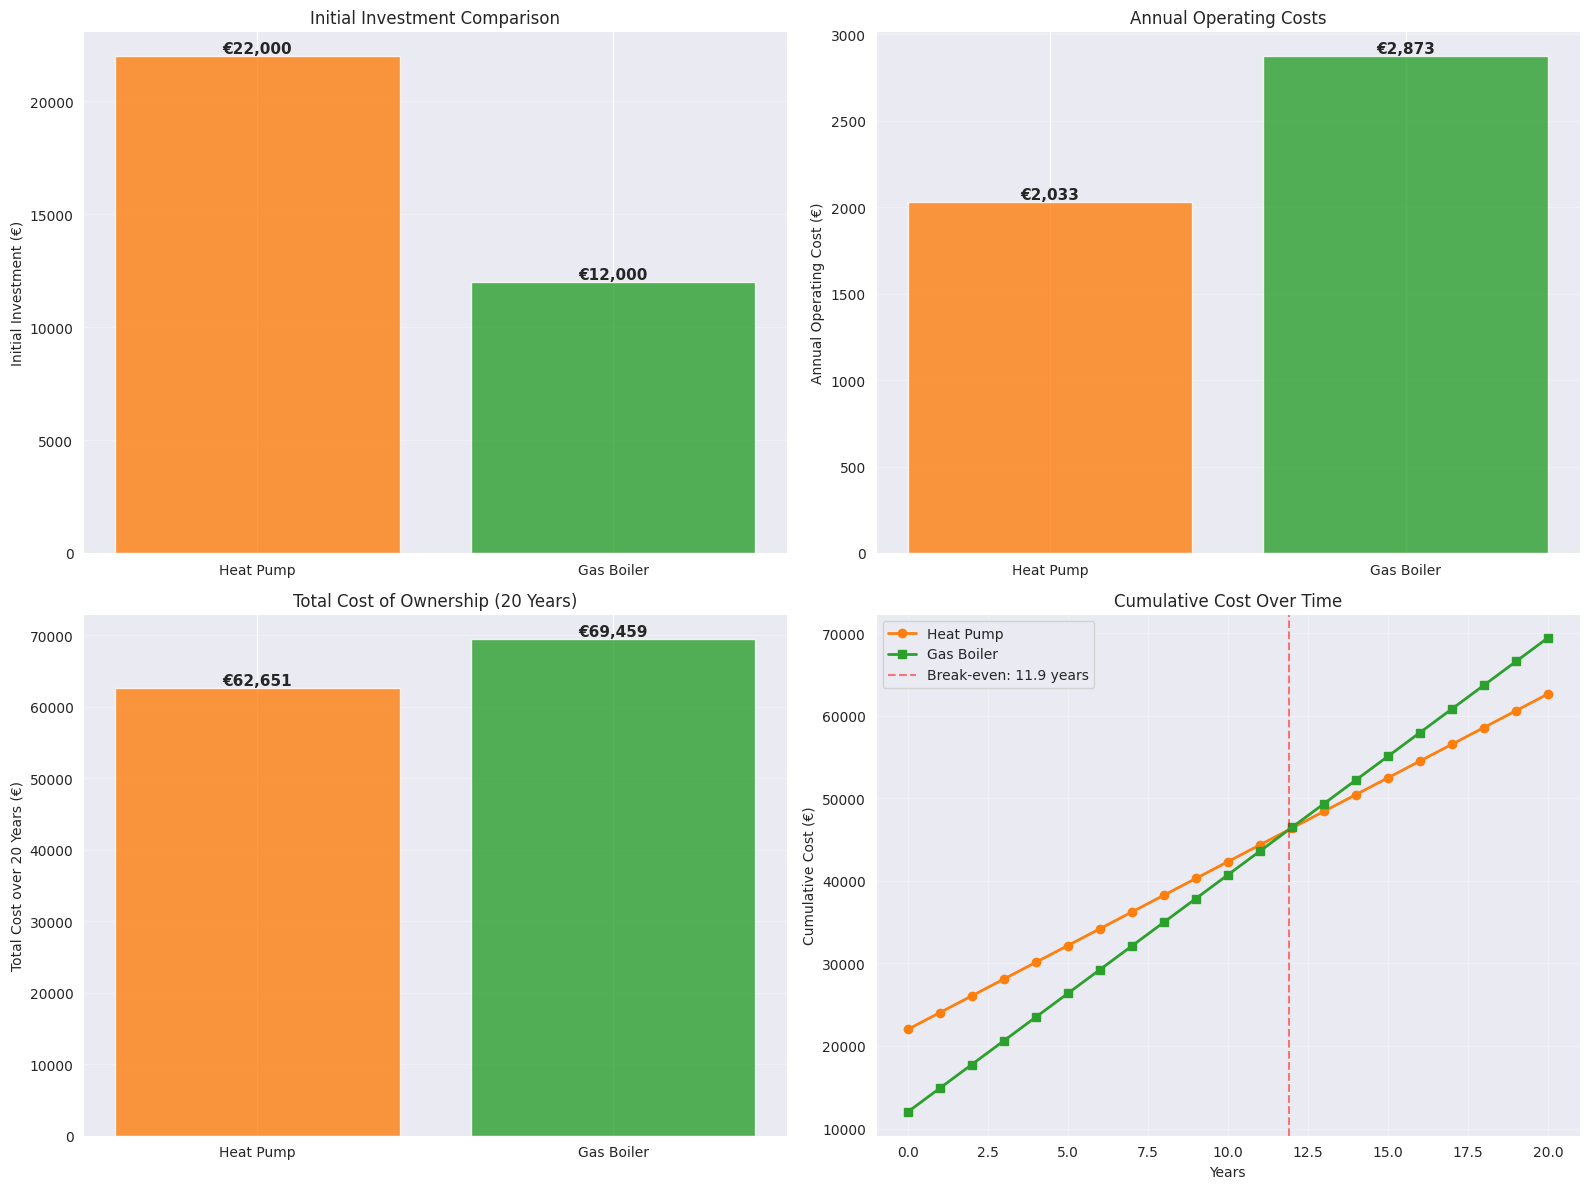


SUMMARY

Heat Pump Performance:
  • Average COP (Coefficient of Performance): 3.91
  • Annual thermal energy delivered: 24,812 kWh
  • Annual electricity consumption: 6,352 kWh

Cost Analysis:
  • Additional investment for heat pump: €10,000
  • Annual savings vs gas boiler: €840.39
  • Payback period: 11.9 years
  • Total savings over 20 years: €6,807.79
  • NPV of additional investment: €2,502.88

Conclusion:
  ✓ Heat pump is MORE ECONOMICAL than gas boiler
  ✓ Net benefit over 20 years: €6,807.79


In [10]:
# Heat Pump vs Gas Boiler Cost Comparison

# Investment costs
heatpump_cost = 22000  # €
gas_boiler_cost = 12000  # €
gas_price_kwh = 0.11

# Load thermal energy data (actual heat delivered)
thermal_energy = pl.read_csv("data/vitocal-thermal-energy.csv").with_columns(
    pl.col("month").str.strptime(pl.Date, "%Y-%m").dt.month().alias("Month")
)

# Load electricity consumption data for heat pump
heatpump_electricity = pl.read_csv(real_heatpump_electricity_demand_file).with_columns(
    pl.col("month").str.strptime(pl.Date, "%Y-%m").dt.month().alias("Month")
)

# Calculate annual totals
annual_thermal_energy = thermal_energy["total"].sum()  # kWh of heat delivered
annual_heatpump_electricity = heatpump_electricity[
    "total"
].sum()  # kWh of electricity consumed

# Calculate heat pump efficiency (COP - Coefficient of Performance)
cop = annual_thermal_energy / annual_heatpump_electricity

# Gas boiler efficiency (typical modern condensing boiler)
gas_boiler_efficiency = 0.95

# Calculate gas consumption needed for same heat output
annual_gas_consumption = annual_thermal_energy / gas_boiler_efficiency  # kWh

# Annual operating costs
heatpump_annual_cost = annual_heatpump_electricity * electricity_price
gas_boiler_annual_cost = annual_gas_consumption * gas_price_kwh

# Annual savings with heat pump
annual_savings = gas_boiler_annual_cost - heatpump_annual_cost

# NPV calculation - comparing heat pump vs gas boiler
system_lifetime = 20  # years (typical heating system lifetime)
discount_rate = 0.03

# Additional investment for heat pump over gas boiler
additional_investment = heatpump_cost - gas_boiler_cost

# NPV of choosing heat pump over gas boiler
heatpump_npv = npf.npv(
    discount_rate, [-additional_investment] + [annual_savings] * system_lifetime
)

# Payback period (based on additional investment)
payback_period = additional_investment / annual_savings

# Total costs over lifetime
heatpump_total_cost = heatpump_cost + (heatpump_annual_cost * system_lifetime)
gas_boiler_total_cost = gas_boiler_cost + (gas_boiler_annual_cost * system_lifetime)

# Create comparison dataframe
comparison_df = pd.DataFrame(
    {
        "Metric": [
            "Initial Investment (€)",
            "Annual Thermal Energy Delivered (kWh)",
            "Annual Energy Consumption (kWh)",
            "System Efficiency (COP / η)",
            "Annual Operating Cost (€)",
            f"Total Cost over {system_lifetime} years (€)",
            "Annual Savings vs Gas Boiler (€)",
            "Additional Investment (€)",
            "Payback Period (years)",
            f"NPV @ {discount_rate*100:.0f}% over {system_lifetime} years (€)",
        ],
        "Heat Pump": [
            heatpump_cost,
            annual_thermal_energy,
            annual_heatpump_electricity,
            cop,
            heatpump_annual_cost,
            heatpump_total_cost,
            annual_savings,
            additional_investment,
            payback_period,
            heatpump_npv,
        ],
        "Gas Boiler": [
            gas_boiler_cost,
            annual_thermal_energy,
            annual_gas_consumption,
            gas_boiler_efficiency,
            gas_boiler_annual_cost,
            gas_boiler_total_cost,
            0,
            0,
            0,
            0,
        ],
    }
)

print("=" * 80)
print("HEAT PUMP VS GAS BOILER COMPARISON")
print("=" * 80)
print(f"Electricity Price: €{electricity_price:.2f}/kWh")
print(f"Gas Price: €{gas_price_kwh:.2f}/kWh")
print(f"System Lifetime: {system_lifetime} years")
print("=" * 80)

display(
    comparison_df.style.format(
        {
            "Heat Pump": lambda x: f"{x:,.2f}" if isinstance(x, (int, float)) else x,
            "Gas Boiler": lambda x: f"{x:,.2f}" if isinstance(x, (int, float)) else x,
        }
    ).hide(axis="index")
)

# Visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Initial investment comparison
systems = ["Heat Pump", "Gas Boiler"]
investments = [heatpump_cost, gas_boiler_cost]
colors = ["#ff7f0e", "#2ca02c"]

bars1 = ax1.bar(systems, investments, color=colors, alpha=0.8)
ax1.set_ylabel("Initial Investment (€)")
ax1.set_title("Initial Investment Comparison")
ax1.grid(True, alpha=0.3, axis="y")

for bar in bars1:
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"€{height:,.0f}",
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold",
    )

# Plot 2: Annual operating costs
annual_costs = [heatpump_annual_cost, gas_boiler_annual_cost]
bars2 = ax2.bar(systems, annual_costs, color=colors, alpha=0.8)
ax2.set_ylabel("Annual Operating Cost (€)")
ax2.set_title("Annual Operating Costs")
ax2.grid(True, alpha=0.3, axis="y")

for bar in bars2:
    height = bar.get_height()
    ax2.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"€{height:,.0f}",
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold",
    )

# Plot 3: Total cost over lifetime
total_costs = [heatpump_total_cost, gas_boiler_total_cost]
bars3 = ax3.bar(systems, total_costs, color=colors, alpha=0.8)
ax3.set_ylabel(f"Total Cost over {system_lifetime} Years (€)")
ax3.set_title(f"Total Cost of Ownership ({system_lifetime} Years)")
ax3.grid(True, alpha=0.3, axis="y")

for bar in bars3:
    height = bar.get_height()
    ax3.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"€{height:,.0f}",
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold",
    )

# Plot 4: Cumulative costs over time
years = np.arange(0, system_lifetime + 1)
heatpump_cumulative = [heatpump_cost + (heatpump_annual_cost * year) for year in years]
gas_cumulative = [gas_boiler_cost + (gas_boiler_annual_cost * year) for year in years]

ax4.plot(
    years,
    heatpump_cumulative,
    marker="o",
    linewidth=2,
    label="Heat Pump",
    color=colors[0],
)
ax4.plot(
    years, gas_cumulative, marker="s", linewidth=2, label="Gas Boiler", color=colors[1]
)
ax4.axvline(
    x=payback_period,
    color="red",
    linestyle="--",
    alpha=0.5,
    label=f"Break-even: {payback_period:.1f} years",
)
ax4.set_xlabel("Years")
ax4.set_ylabel("Cumulative Cost (€)")
ax4.set_title("Cumulative Cost Over Time")
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary
print("\n" + "=" * 80)
print("SUMMARY")
print("=" * 80)
print(f"\nHeat Pump Performance:")
print(f"  • Average COP (Coefficient of Performance): {cop:.2f}")
print(f"  • Annual thermal energy delivered: {annual_thermal_energy:,.0f} kWh")
print(f"  • Annual electricity consumption: {annual_heatpump_electricity:,.0f} kWh")

print(f"\nCost Analysis:")
print(f"  • Additional investment for heat pump: €{additional_investment:,.0f}")
print(f"  • Annual savings vs gas boiler: €{annual_savings:,.2f}")
print(f"  • Payback period: {payback_period:.1f} years")
print(
    f"  • Total savings over {system_lifetime} years: €{(gas_boiler_total_cost - heatpump_total_cost):,.2f}"
)
print(f"  • NPV of additional investment: €{heatpump_npv:,.2f}")

print(f"\nConclusion:")
if heatpump_npv > 0:
    print(f"  ✓ Heat pump is MORE ECONOMICAL than gas boiler")
    print(
        f"  ✓ Net benefit over {system_lifetime} years: €{gas_boiler_total_cost - heatpump_total_cost:,.2f}"
    )
else:
    print(f"  ✗ Gas boiler is more economical")
    print(
        f"  ✗ Additional cost with heat pump: €{heatpump_total_cost - gas_boiler_total_cost:,.2f}"
    )

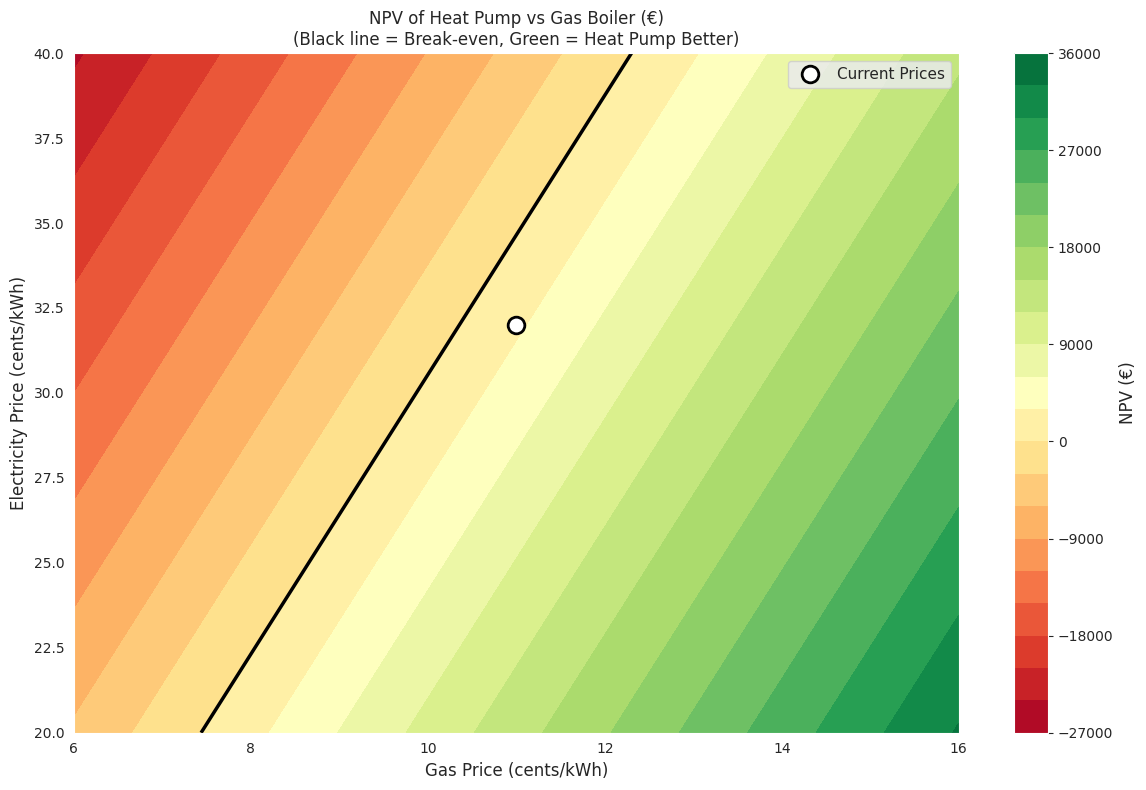

SENSITIVITY ANALYSIS: ELECTRICITY/GAS PRICE RATIO

Current Situation:
  • Electricity price: 32.0 cents/kWh
  • Gas price: 11.0 cents/kWh
  • Price ratio (Elec/Gas): 2.91
  • Current NPV: €2,502.88

  ✓ Heat pump is ECONOMICAL at current prices

Break-even Analysis:
  • Max electricity price for positive NPV (at gas=11.0 cents): 40.0 cents/kWh
  • Electricity price can increase by 25.0% before becoming uneconomical
  • Min gas price for positive NPV (at elec=32.0 cents): 6.0 cents/kWh
  • Gas price can decrease by 45.5% before heat pump becomes uneconomical

Technical Details:
  • Heat pump COP: 3.91
  • Theoretical break-even ratio: 3.71 (COP × gas efficiency)
  • Current price ratio: 2.91


In [13]:
# Sensitivity Analysis: Impact of Electricity/Gas Price Ratio

# Create a range of price scenarios
base_gas_price = 0.11  # €/kWh
gas_prices = np.linspace(0.06, 0.16, 20)  # Range from 6 to 16 cents/kWh
electricity_prices = np.linspace(0.20, 0.40, 20)  # Range from 20 to 40 cents/kWh

# Create meshgrid for 2D analysis
gas_grid, elec_grid = np.meshgrid(gas_prices, electricity_prices)

# Calculate NPV for each price combination
npv_grid = np.zeros_like(gas_grid)

for i in range(len(electricity_prices)):
    for j in range(len(gas_prices)):
        elec_p = electricity_prices[i]
        gas_p = gas_prices[j]

        # Calculate annual costs
        hp_cost = annual_heatpump_electricity * elec_p
        gb_cost = annual_gas_consumption * gas_p
        savings = gb_cost - hp_cost

        # Calculate NPV
        npv_grid[i, j] = npf.npv(
            discount_rate, [-additional_investment] + [savings] * system_lifetime
        )

# Create visualization
fig, ax = plt.subplots(figsize=(12, 8))

contour = ax.contourf(
    gas_grid * 100, elec_grid * 100, npv_grid, levels=20, cmap="RdYlGn"
)
ax.contour(
    gas_grid * 100,
    elec_grid * 100,
    npv_grid,
    levels=[0],
    colors="black",
    linewidths=2.5,
)
ax.plot(
    base_gas_price * 100,
    electricity_price * 100,
    "o",
    markersize=12,
    markerfacecolor="white",
    markeredgecolor="black",
    markeredgewidth=2,
    label="Current Prices",
)
ax.set_xlabel("Gas Price (cents/kWh)", fontsize=12)
ax.set_ylabel("Electricity Price (cents/kWh)", fontsize=12)
ax.set_title(
    "NPV of Heat Pump vs Gas Boiler (€)\n(Black line = Break-even, Green = Heat Pump Better)",
)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
cbar = plt.colorbar(contour, ax=ax)
cbar.set_label("NPV (€)", fontsize=12)

plt.tight_layout()
plt.show()

# Calculate current NPV
current_hp_cost = annual_heatpump_electricity * electricity_price
current_gb_cost = annual_gas_consumption * base_gas_price
current_savings = current_gb_cost - current_hp_cost
current_npv = npf.npv(
    discount_rate, [-additional_investment] + [current_savings] * system_lifetime
)

# Find break-even electricity price (at current gas price)
# Start from high prices and find where NPV crosses zero
breakeven_elec = None
for elec_p in reversed(electricity_prices):
    hp_cost = annual_heatpump_electricity * elec_p
    gb_cost = annual_gas_consumption * base_gas_price
    savings = gb_cost - hp_cost
    npv = npf.npv(discount_rate, [-additional_investment] + [savings] * system_lifetime)
    if npv <= 0:
        breakeven_elec = elec_p
        break

# Find break-even gas price (at current electricity price)
# Start from low prices and find where NPV crosses zero
breakeven_gas = None
for gas_p in gas_prices:
    hp_cost = annual_heatpump_electricity * electricity_price
    gb_cost = annual_gas_consumption * gas_p
    savings = gb_cost - hp_cost
    npv = npf.npv(discount_rate, [-additional_investment] + [savings] * system_lifetime)
    if npv <= 0:
        breakeven_gas = gas_p
        break

print("=" * 80)
print("SENSITIVITY ANALYSIS: ELECTRICITY/GAS PRICE RATIO")
print("=" * 80)

print(f"\nCurrent Situation:")
print(f"  • Electricity price: {electricity_price*100:.1f} cents/kWh")
print(f"  • Gas price: {base_gas_price*100:.1f} cents/kWh")
print(f"  • Price ratio (Elec/Gas): {electricity_price/base_gas_price:.2f}")
print(f"  • Current NPV: €{current_npv:,.2f}")

if current_npv > 0:
    print(f"\n  ✓ Heat pump is ECONOMICAL at current prices")
else:
    print(f"\n  ✗ Heat pump is NOT ECONOMICAL at current prices")

if breakeven_elec:
    print(f"\nBreak-even Analysis:")
    print(
        f"  • Max electricity price for positive NPV (at gas={base_gas_price*100:.1f} cents): {breakeven_elec*100:.1f} cents/kWh"
    )
    if current_npv > 0:
        margin = ((breakeven_elec - electricity_price) / electricity_price) * 100
        print(
            f"  • Electricity price can increase by {margin:.1f}% before becoming uneconomical"
        )

if breakeven_gas:
    print(
        f"  • Min gas price for positive NPV (at elec={electricity_price*100:.1f} cents): {breakeven_gas*100:.1f} cents/kWh"
    )
    if current_npv > 0:
        margin = ((base_gas_price - breakeven_gas) / base_gas_price) * 100
        print(
            f"  • Gas price can decrease by {margin:.1f}% before heat pump becomes uneconomical"
        )

print(f"\nTechnical Details:")
print(f"  • Heat pump COP: {cop:.2f}")
print(
    f"  • Theoretical break-even ratio: {cop * gas_boiler_efficiency:.2f} (COP × gas efficiency)"
)
print(f"  • Current price ratio: {electricity_price / base_gas_price:.2f}")